# Мастерская "Метчинг товаров"

## Задача:

* разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из base;

* оценить качество алгоритма по метрике accuracy@5

## Описание данных:

* base.csv - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

* train.csv - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

* validation.csv - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из base.csv

* validation_answer.csv - правильные ответы к предыдущему файлу.

## План работы:

* Загрузить данные, ознакомиться с ними, провести EDA.

* При помощи библиотеки FAISS разработать ранжирующую модель

# Начало работы

## Импорт библиотек

In [1]:
!pip install faiss-cpu

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import faiss

Также зададим параметр max_columns на 80 чтобы все столбцы отображались.

In [3]:
pd.set_option('display.max_columns', 80)

Количество соседей для метрики:

In [4]:
k = 5

## Считаем данные, напишем функции для EDA

In [5]:
base = pd.read_table('/kaggle/input/yandex/base.csv', index_col=0, sep=',')

train = pd.read_csv('/kaggle/input/yandex/train.csv', index_col=0) 

valid = pd.read_csv('/kaggle/input/yandex/validation.csv', index_col=0)

test = pd.read_csv('/kaggle/input/yandex/validation_answer.csv', index_col=0)

In [6]:
def show_df(df):
    display(df.head(5))
    display(df.shape)

In [7]:
def eda(df):
    df.info()
    print()
    print('количество полных дубликатов в таблице:', df.duplicated().sum())
    display(df.describe().T)
    display(df.head(5))
    df.hist(figsize=(30, 30), bins=50)
    print()
    print("Пропуски в таблице:", df.shape[0] - df.count())

In [8]:
show_df(base)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

(2918139, 72)

In [9]:
show_df(train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-

(100000, 73)

In [10]:
show_df(valid)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255

(100000, 72)

In [11]:
show_df(test)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


(100000, 1)

## Начнём EDA:

### Посмотрим на данные, построим графики:

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


,count,mean,std,min,25%,50%,75%,max
0,2918139.0,-86.229474,24.891320,-199.468700,-103.065438,-86.231500,-69.256577,21.515549
1,2918139.0,8.080077,4.953387,-13.914608,4.708491,8.038950,11.470066,29.937210
2,2918139.0,-44.580804,38.631660,-240.073400,-69.559490,-43.816605,-19.625266,160.937230
3,2918139.0,-146.634991,19.844805,-232.667140,-159.905060,-146.776810,-133.327655,-51.374780
4,2918139.0,111.316628,46.348090,-105.582960,80.507945,111.873000,142.374275,319.664500
...,...,...,...,...,...,...,...,...
67,2918139.0,23.544896,55.342236,-233.138170,-12.516241,23.416494,59.755113,314.898770
68,2918139.0,74.959301,61.345005,-203.601620,33.775737,74.929970,115.876040,339.573850
69,2918139.0,115.566716,21.175183,15.724480,101.686670,116.024445,129.552375,214.706340
70,2918139.0,-799.339026,385.413088,-1297.931468,-1074.464888,-1074.464888,-505.744456,98.770811


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62


Пропуски в таблице: 0     0
1     0
2     0
3     0
4     0
     ..
67    0
68    0
69    0
70    0
71    0
Length: 72, dtype: int64


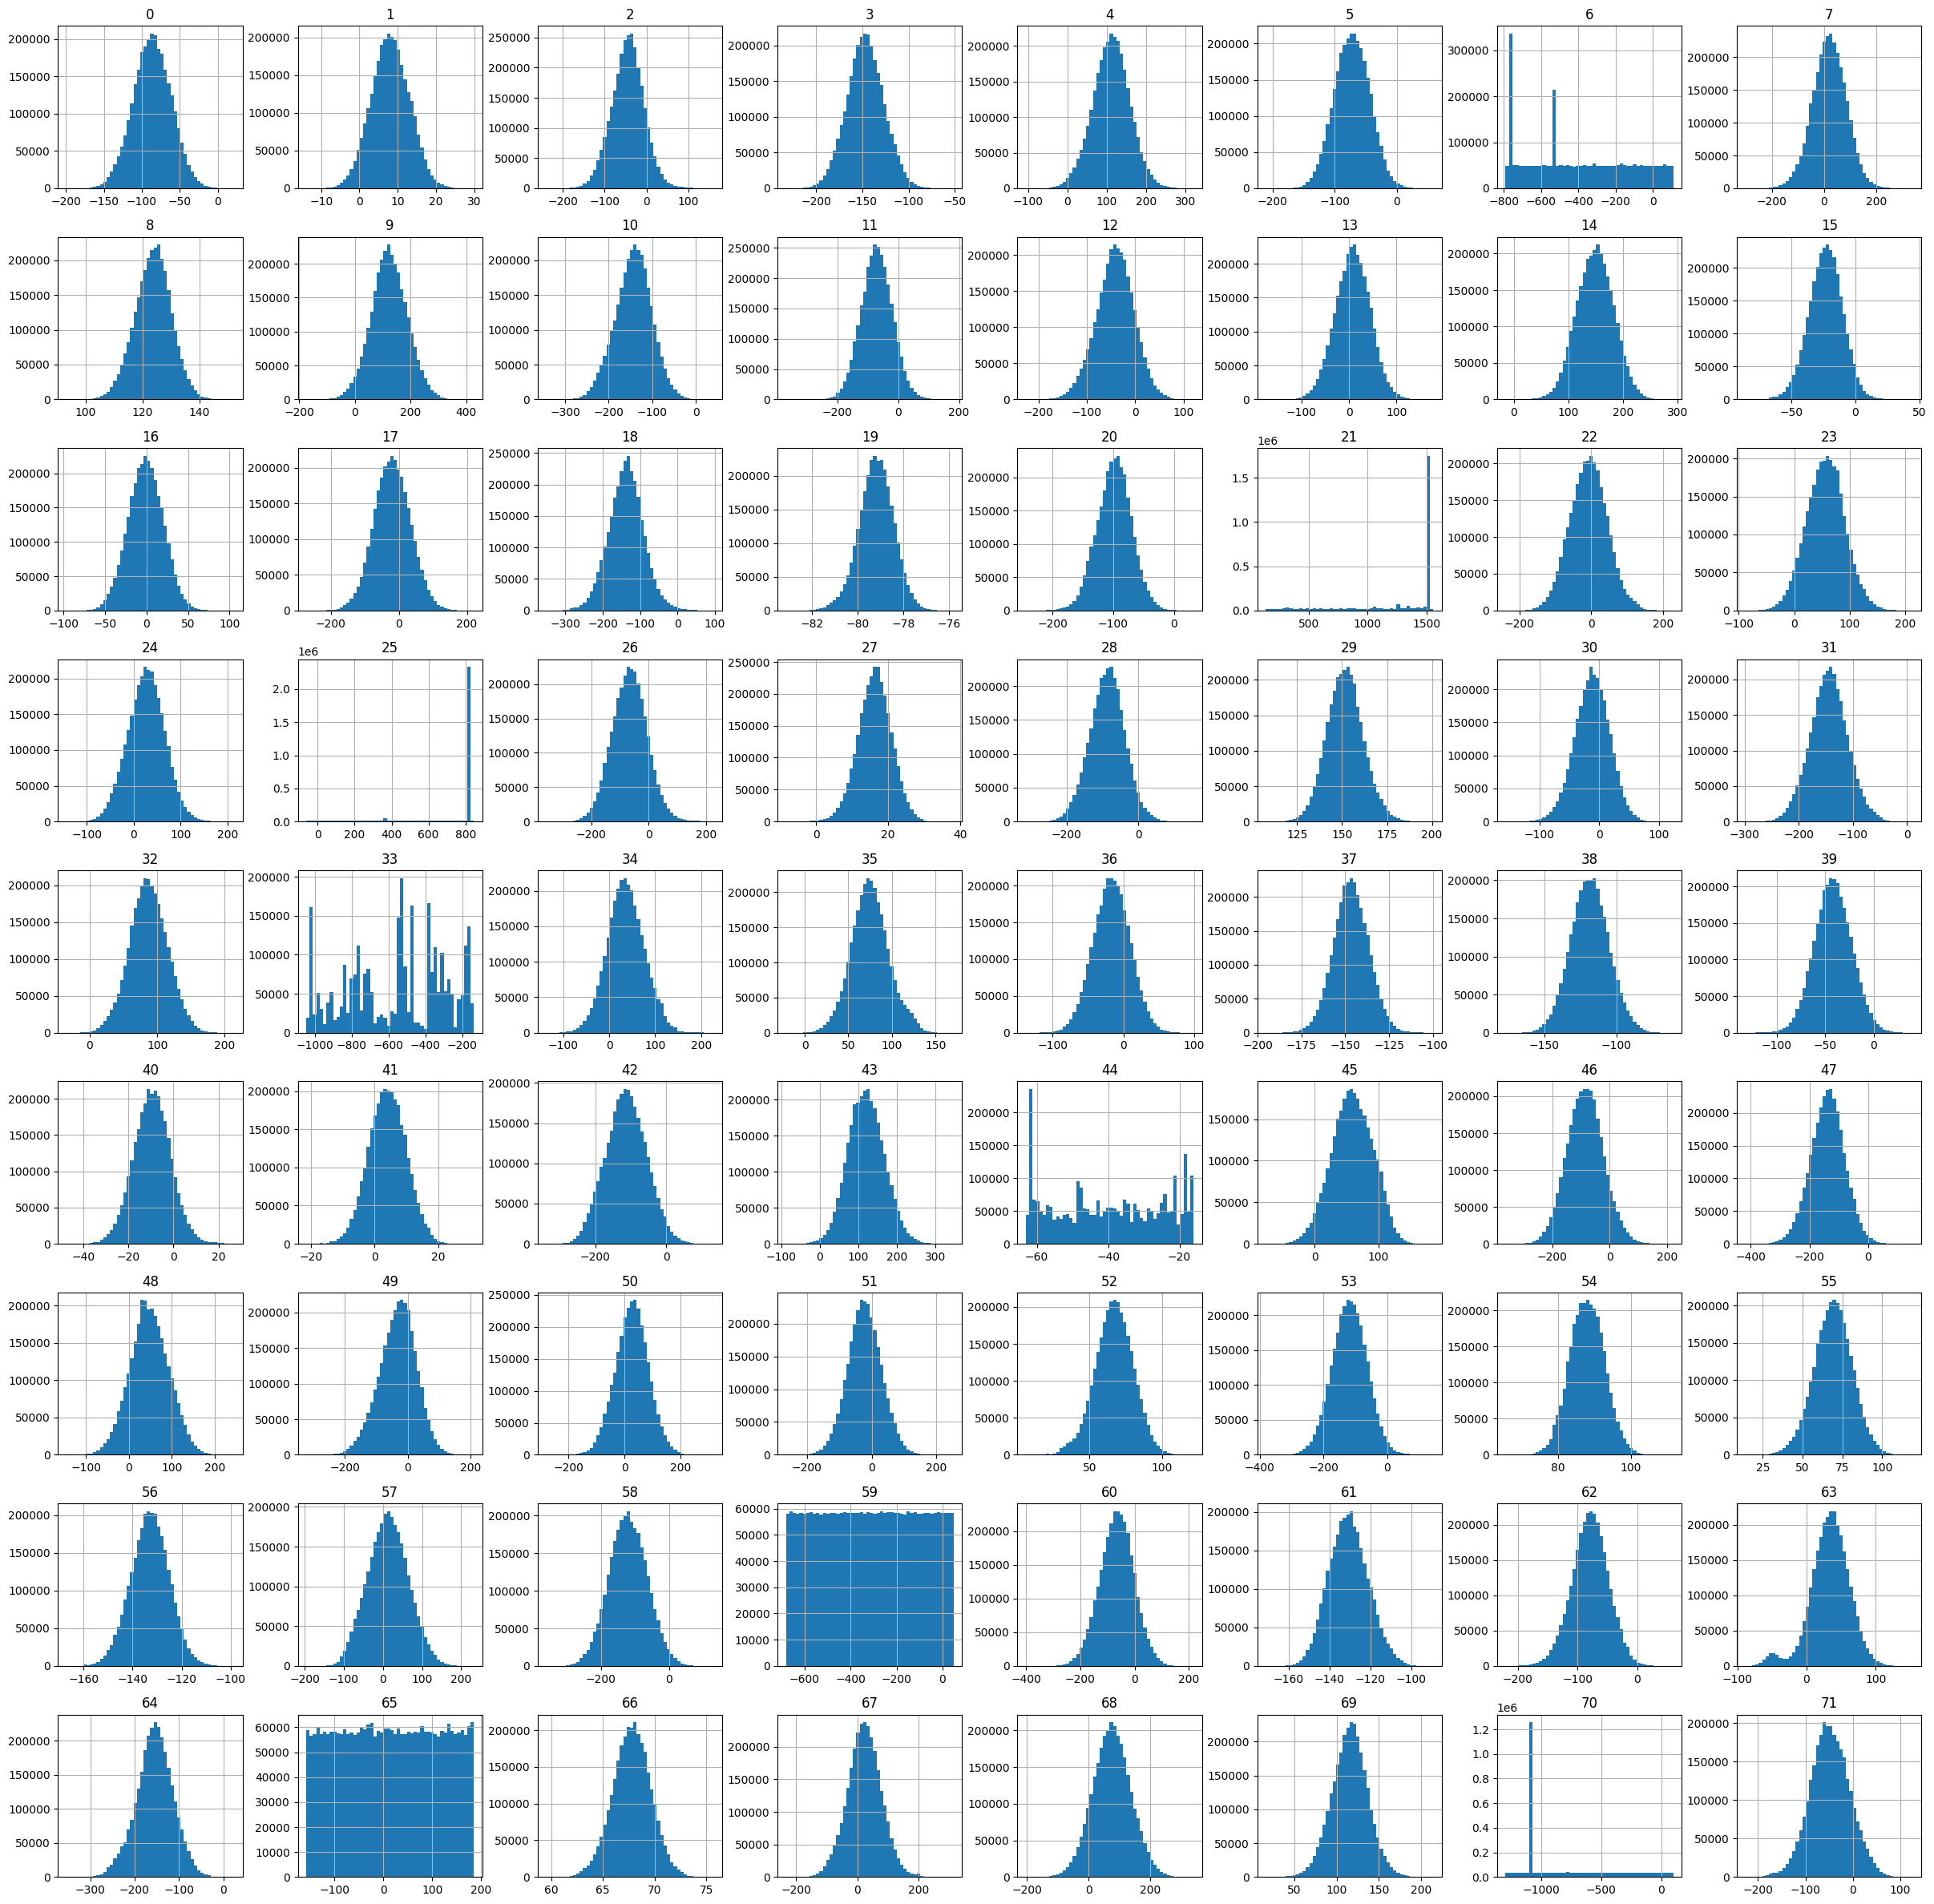

In [12]:
eda(base)

### Чистка данных:

В таблице base большая часть признаков распределена нормально, однако некоторые признаки распределены беспорядочно, их номера: 6, 21, 25, 33, 44, 59, 65, 70. Предлагаю ознакомится с ними подробнее, посмотреть на корелляции, в случае чего эти признаки отбросим. 

In [ ]:
linear_corr_matrix = base.corr()

nonlinear_corr_matrix = base.corr(method='spearman')

plt.figure(figsize=(128, 84))
sns.heatmap(linear_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Linear Correlation Matrix')
plt.show()

plt.figure(figsize=(128, 84))
sns.heatmap(nonlinear_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Non-linear Correlation Matrix')
plt.show()

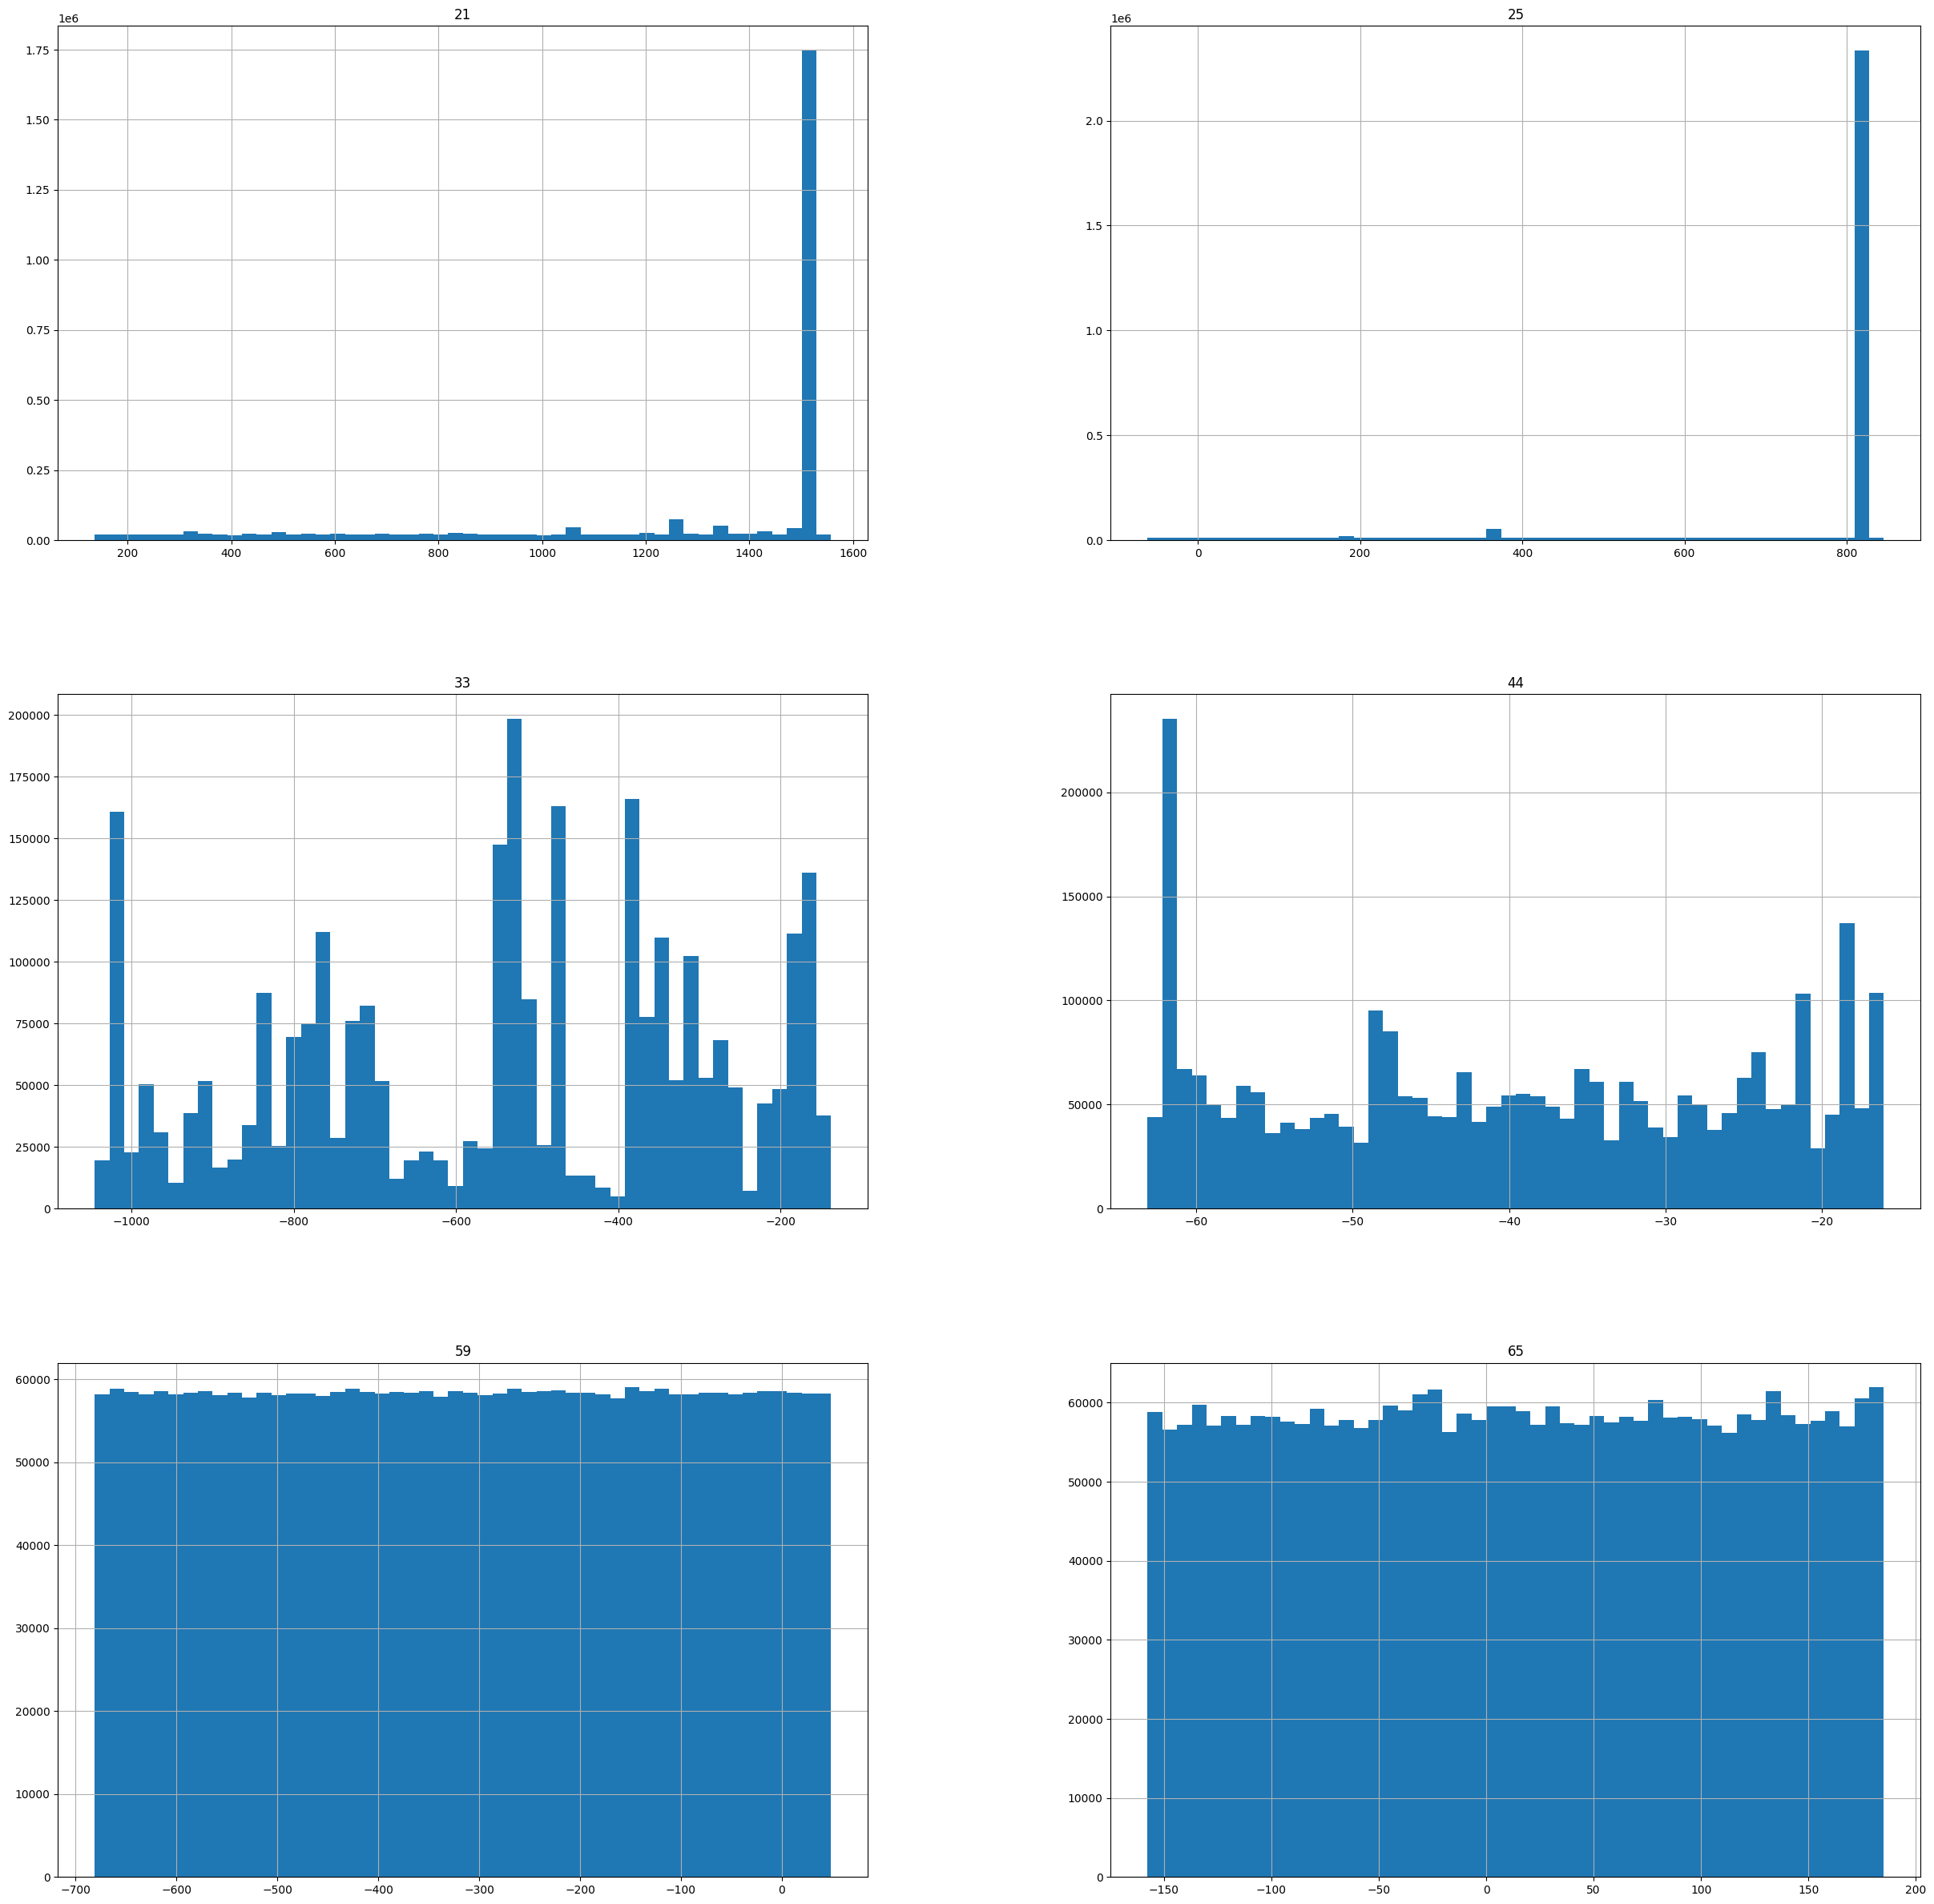

In [ ]:
features = ['21','25','33','44','59','65']

base[features].hist(figsize=(30, 30), bins=50);

При приближённом осмотре видно, что проблем с линейными и нелинейными зависимостями нет. Я предлагаю отбросить эти признаки.

P.S. Изначально я попробовал отбросить все признаки, которые не имеют нормального распределения ( 6, 21, 25, 33, 44, 59, 65, 70), однако метрика точности при этом была околонулевая. Я попробовал разные варианты, в итоге наиболее эффективно модель работает если мы оставим признаки 6 и 70.

In [15]:
base = base.drop(features, axis=1)
train = train.drop(features, axis=1)
valid = valid.drop(features, axis=1)

### Масштабируем признаки:

Я буду использовать StandardScaler(), посмотрим что это даст в результате

In [16]:
target = train["Target"]
train.drop("Target", axis=1, inplace=True)

show_df(train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,-70.140520,78.420360,108.032776,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,-34.744545,82.487110,-28.450592,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,21.459618,-137.41136,-40.812233,4.669178,-151.69771,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,-52.500970,-34.165775,52.958652,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,19.957405,34.834290,-8.820732,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,16.612400,116.284290,33.754898,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-24.104229,75.142590,-207.34506,93.436935,51.505203,-135.47598,99.803660,-49.158073,-127.747860,-103.34170,-68.770600,45.028910,-196.09207,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351


(100000, 66)

In [17]:
scaler = StandardScaler()
scaler.fit(base)

base = pd.DataFrame(scaler.transform(base), index=base.index, columns = base.columns)
train = pd.DataFrame(scaler.transform(train), index=train.index, columns = train.columns)
valid = pd.DataFrame(scaler.transform(valid), index=valid.index, columns = valid.columns)

In [18]:
show_df(train)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60,61,62,63,64,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,1.299519,1.996888,0.063774,-1.879671,1.644100,-0.537626,0.165148,0.279598,-2.296794,-1.459626,1.320710,0.335633,0.348338,-0.074182,1.467578,-0.528330,-0.137619,-2.199224,-0.526967,0.893981,0.135834,-1.218252,0.632892,2.088698,-0.138746,-0.795630,-2.008673,-0.200075,-0.533139,0.317073,0.689298,0.313108,-0.793275,1.575643,-0.460325,1.082610,0.384758,-0.379061,-0.244658,-0.144466,0.623425,0.727980,-0.489634,-1.815781,-0.913808,-1.712483,0.714613,-0.330307,-0.310548,-0.269749,0.243144,1.492605,1.487568,-0.395721,-1.573302,-0.193435,-0.179583,-0.866975,1.274319,-0.024410,-1.035388,0.197184,-0.200786,0.906575,0.995267,0.522963
1-query,-0.062146,-0.257159,0.324249,-1.543245,0.204684,-0.419328,1.095696,-1.538329,0.193777,0.246358,-0.826778,-0.294981,2.157804,-1.771830,-1.551709,0.298688,0.080464,1.320173,-0.385964,0.699576,0.195050,-0.537200,0.751247,-1.416127,-1.158335,2.207661,-1.039072,0.160884,2.086926,0.814522,0.008768,-0.278611,0.778098,-0.547298,1.009545,-1.672834,-0.081826,0.275359,0.722288,-0.090823,0.605429,1.132864,0.392376,0.946494,-0.231800,0.155840,0.805338,0.281748,0.678224,0.106981,-1.082974,-1.266821,-0.140726,-0.770735,-1.720258,1.382837,-0.704733,1.254600,-0.991073,0.075152,0.207972,0.028031,0.244774,0.709459,-0.611690,-0.083491
2-query,1.456328,-0.855696,-1.851792,-1.701553,1.700433,0.750504,1.543015,-0.791080,0.328335,1.352615,1.362356,0.668101,1.479850,-2.415226,-0.329309,-0.027972,-2.223497,0.050269,-1.227532,1.077830,1.027371,-0.878850,-2.643714,0.674421,0.783830,0.995513,0.743161,0.696336,0.407097,-1.117370,0.424820,-2.206801,1.052243,0.217402,0.222918,-1.164573,-1.928611,-0.942296,0.071421,0.856565,0.722909,-0.324238,-0.593699,0.446080,0.122435,0.021703,1.378345,0.738322,0.836741,0.407248,0.718825,-0.509248,0.763422,-0.101015,-1.377149,-0.126222,-0.894063,0.886224,1.548929,-0.348054,-0.978114,-0.092956,2.240614,0.300576,-0.713847,0.604677
3-query,1.543467,0.203199,-1.833235,1.291201,-0.359536,-1.322073,-1.409605,0.916179,0.050167,1.834418,-0.081019,-1.748992,0.703739,-0.374392,-0.893277,-1.638078,0.503843,0.637105,-0.421133,0.528090,0.693100,0.515318,-0.635598,-0.912042,-0.964573,0.272452,0.575554,-1.035956,-1.497437,0.208424,-0.837875,1.328225,-0.432656,-0.293640,-0.571839,2.077953,0.711239,0.575637,-0.666996,-0.287751,0.044801,2.014451,0.749256,1.148800,0.515765,-2.328709,1.554671,0.070583,-2.275224,-0.361816,-0.110469,-0.566342,0.210479,0.439825,0.607510,-1.416759,-0.055445,0.573141,0.388351,0.227494,-2.007464,1.491032,0.133987,0.128028,-0.713847,0.668019
4-query,0.265046,1.284537,-0.370748,-0.021041,-1.169187,1.977993,0.261015,0.399148,0.355099,-0.326947,0.863249,1.192634,-0.249281,0.597574,-0.166367,2.201182,-2.128363,0.546642,1.280767,0.162002,0.721888,0.450956,1.734850,0.181279,-0.642122,-2.102888,1.372038,0.590617,-0.310752,-0.067855,-0.300493,1.286411,-0.100830,1.290977,0.199335,0.181835,1.173404,0.216465,-1.618583,-0.483103,1.547941,0.651837,-1.048251,1.617877,0.705034,1.357857,0.357874,-0.046138,0.623158,-1.635063,1.132887,-1.481232,-0.328895,1.694938,1.275118,-1.005156,2.855665,0.336621,0.406133,-1.001615,-0.474647,0.341715,0.043401,-1.090276,-0.713847,0.638160


(100000, 66)

### Посмотрим на базовую модель:

Пусть обучающая выборка будет состоять из 300000 записей, 10% от всех данных

In [19]:
index_part = 300000


dimension = base.shape[1]
index = faiss.IndexFlatL2(dimension)

index.add(np.ascontiguousarray(base.values[:index_part, :]).astype('float32'))
index.ntotal

base_index = {k: v for k, v in enumerate(base.index.to_list())}

D, I = index.search(np.ascontiguousarray(train.values).astype('float32'), k)

acc = 0
for t, el in zip(target.values.tolist(), I.tolist()):
    acc += int(t in [base_index[r] for r in el])

accuracy = 100 * acc / len(I)
print("Метрика accuracy@5:", accuracy)

Метрика accuracy@5: 23.55


### Вывод:

Проблем, которые потребовали сложного и обдуманного решения в обработке не обнаружено. Оставшаяся часть данных, кроме 2 признаков, распределена равномерно, без разбросов. Матрицы корреляции также не выявили проблем с зависимостями.

## Воспользуемся кластеризацией и подберём модель

Для начала выберем 30 кластеров, как это было к примеру на вебинаре. Также будем искать по 5 соседним кластерам.

In [20]:
cells = 30
nprobe = 5

In [21]:
dimension = base.shape[1]
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, cells)

index.nprobe = nprobe

index.train(np.ascontiguousarray(base.iloc[:index_part, :]).astype('float32'))
index.add(np.ascontiguousarray(base).astype('float32'))

index.is_trained


D, I = index.search(np.ascontiguousarray(train.values).astype('float32'), k)

acc = 0
for t, el in zip(target.values.tolist(), I.tolist()):
    acc += int(t in [base_index[r] for r in el])

    
accuracy = 100 * acc / len(I)
print("Метрика accuracy@5:", accuracy)

Метрика accuracy@5: 71.072


# Вывод:

В данном проекте по поиску ближайших объектов было выполнено следующее:

## Просмотр данных:

Считали данные, посмотрели на их содержимое. Единственное что пугает - их размер, однако это решается кластеризацией.

## Выполнили обработку данных:

Вывели информацию по таблицам, посмотрели на пропуски, дубликаты, вывели графики по признакам. Выявили, что некоторые признаки распределены не нормально. Методом научного тыка оставили из списка подозрительных столбцов 2, остальные удалили, таким образом получили наиболее эффективный результат. При помощи StandartScaler() выполнили масштабирование.

## Создали модель:

Для начала использовали 30 кластеров и поиск по 5 соседним, таким образом получилось достичь 71 очков метрики. В последствии возможны улучшения, однако результат неплох и на текущий момент.